# Feature engineering: creating new variables from raw data

In this notebook, a series of new variables are created from raw rock physical properties. These variables are thought to give insight on the downhole texture of each raw variable and on the relationship between neighboring points.

These new variables are:
- calculated from wavelets at different scales
- estimations of the local entropy
- estimation of the local gradient
- moving averages with variable window
- moving standard deviation with variable window (still to be done)
- local max and min

First, we import all the tools we need, and the training data:

In [32]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from pandas import set_option
# set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

###### Import packages needed for the make_vars functions
from scipy.interpolate import interp1d
import pywt

from skimage.filters.rank import entropy
from skimage.morphology import rectangle
from skimage.util import img_as_ubyte

##### import stuff from scikit learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, LeaveOneGroupOut, LeavePGroupsOut

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [2]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


## Creating variable-making functions

In [3]:
def make_dwt_vars_cD(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    max_level = max(levels)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]

            cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(temp_data,wave,level=4,mode='symmetric')
            dict_cD_levels = {1:cD_1, 2:cD_2, 3:cD_3, 4:cD_4}
            #new_depth = np.linspace(min(depth),max(depth),len(cD))
            #fD = interp1d(new_depth,cD,kind='nearest')
                
            for i in levels:
                new_depth = np.linspace(min(depth),max(depth),len(dict_cD_levels[i]))
                fA = interp1d(new_depth,dict_cD_levels[i],kind='nearest')
                #temp_df[log + '_cD_step_level_' + str(i)] = fD(depth)
                temp_df[log + '_cD_level_' + str(i)] = fA(depth)
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_df],axis=1)

In [4]:
def make_dwt_vars_cA(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    max_level = max(levels)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]
              
            for i in levels:
                
                    cA_cD = pywt.wavedec(temp_data,wave,level=i,mode='symmetric')
                    cA = cA_cD[0]
                    new_depth = np.linspace(min(depth),max(depth),len(cA))
                    fA = interp1d(new_depth,cA,kind='nearest')
                    #temp_df[log + '_cD_step_level_' + str(i)] = fD(depth)
                    temp_df[log + '_cA_level_' + str(i)] = fA(depth)
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_df],axis=1)

In [5]:
def make_entropy_vars(wells_df,logs,l_foots):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])
    
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        
        for log in logs:
            temp_data = grouped.get_group(key)[log]
            image = np.vstack((temp_data,temp_data,temp_data))
            image -= np.median(image) 
            image /= np.max(np.abs(image))
            image = img_as_ubyte(image)
            
            for l_foot in l_foots:     
                footprint = rectangle(l_foot,3)
                temp_df[log + '_entropy_foot' + str(l_foot)] = entropy(image,footprint)[0,:]
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
    
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [6]:
def make_gradient_vars(wells_df,logs,dx_list):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])
    
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth

        for log in logs:

            temp_data = grouped.get_group(key)[log]

            for dx in dx_list:

                temp_df[log + 'gradient_dx' + str(dx)] = np.gradient(temp_data,dx)

        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df) 
    
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [7]:
def make_moving_av_vars(wells_df,logs,windows):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])

    for key in grouped.groups.keys():

        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        
        for log in logs:

            temp_data = grouped.get_group(key)[log]
            
            for window in windows:
                temp_df[log + '_moving_av_' + str(window) + 'ft'] = pd.rolling_mean(arg=temp_data, window=window, min_periods=1, center=True)                
                
        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_df = new_df.append(temp_df) 

        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [8]:
def make_moving_std_vars(wells_df,logs,windows):
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])

    for key in grouped.groups.keys():
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        
        for log in logs:

            temp_data = grouped.get_group(key)[log]
            
            for window in windows:
                temp_df[log + '_moving_std_' + str(window) + 'ft'] = pd.rolling_std(arg=temp_data, window=window, min_periods=1, center=True)                
                
        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_df = new_df.append(temp_df) 

        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [9]:
def make_moving_max_vars(wells_df,logs,windows):
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])

    for key in grouped.groups.keys():
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        
        for log in logs:

            temp_data = grouped.get_group(key)[log]
            
            for window in windows:
                temp_df[log + '_moving_max_' + str(window) + 'ft'] = pd.rolling_max(arg=temp_data, window=window, min_periods=1, center=True)                
                
        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_df = new_df.append(temp_df) 

        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [10]:
def make_moving_min_vars(wells_df,logs,windows):
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])

    for key in grouped.groups.keys():
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        
        for log in logs:

            temp_data = grouped.get_group(key)[log]
            
            for window in windows:
                temp_df[log + '_moving_min_' + str(window) + 'ft'] = pd.rolling_min(arg=temp_data, window=window, min_periods=1, center=True)                
                
        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_df = new_df.append(temp_df) 

        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [11]:
def make_rolling_marine_ratio_vars(wells_df, windows):

    grouped = wells_df.groupby(['Well Name'])
    new_var = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        NM_M = grouped.get_group(key)['NM_M']
        
        for window in windows:
    
            temp_df['Depth'] = grouped.get_group(key)['Depth']
            temp_df['Well Name'] = [key for _ in range(len(NM_M))]
            temp_df['NM_M'] = grouped.get_group(key)['NM_M']
            #We initialize a new variable
            temp_df['Marine_ratio_' + str(window) + '_centered'] = pd.rolling_mean(arg=temp_df['NM_M'], window=window, min_periods=1, center=True)

        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_var = new_var.append(temp_df)

            
    new_var = new_var.sort_index()
    new_var =new_var.drop(['Well Name','Depth','NM_M'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_var],axis=1)

In [12]:
def make_distance_to_M_up_vars(wells_df):
    grouped = wells_df.groupby(['Well Name'])
    new_var = pd.DataFrame()

    for key in grouped.groups.keys():

        NM_M = grouped.get_group(key)['NM_M'].values

        #We create a temporary dataframe that we reset for every well
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        temp_df['Well Name'] = [key for _ in range(len(NM_M))]
        #We initialize a new variable
        dist_mar_up = np.zeros(len(NM_M))

        # A variable counting the interval from the ipper marine deposit
        # We initialize it to -99999 since we do not know what's abpve the first log
        count = -1

        for i in range(len(NM_M)):

            if ((NM_M[i] == 1) & (count>-1)):

                count+=0.5
                dist_mar_up[i] += count

            elif NM_M[i] == 2:

                count=0

            else:
                dist_mar_up[i] = count

        temp_df['dist_M_up'] = dist_mar_up

        # We append each well variable to a larger dataframe
        # We use a dataframe to preserve the index
        new_var = new_var.append(temp_df)
    
    new_var = new_var.sort_index()
    new_var =new_var.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_var],axis=1)

In [13]:
def make_distance_to_M_down_vars(wells_df):
    grouped = wells_df.groupby(['Well Name'])
    new_var = pd.DataFrame()

    for key in grouped.groups.keys():

        NM_M = grouped.get_group(key)['NM_M'].values

        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        temp_df['Well Name'] = [key for _ in range(len(NM_M))]

        dist_mar_down = np.zeros(len(NM_M))
        count = -1

        for i in range(len(NM_M)-1,-1,-1):

            if ((NM_M[i] == 1) & (count>-1)):

                count+=0.5
                dist_mar_down[i] += count

            elif NM_M[i] == 2:            
                count=0

            else:
                dist_mar_down[i] = count

        temp_df['dist_M_down'] = dist_mar_down

        new_var = new_var.append(temp_df)
        
    new_var = new_var.sort_index()
    new_var =new_var.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_var],axis=1)

In [14]:
def make_distance_to_NM_up_vars(wells_df):
    grouped = wells_df.groupby(['Well Name'])
    new_var = pd.DataFrame()

    for key in grouped.groups.keys():

        NM_M = grouped.get_group(key)['NM_M'].values

        #We create a temporary dataframe that we reset for every well
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        temp_df['Well Name'] = [key for _ in range(len(NM_M))]
        #We initialize a new variable
        dist_mar_up = np.zeros(len(NM_M))

        # A variable counting the interval from the ipper marine deposit
        # We initialize it to -99999 since we do not know what's abpve the first log
        count = -1

        for i in range(len(NM_M)):

            if ((NM_M[i] == 2) & (count>-1)):

                count+=0.5
                dist_mar_up[i] += count

            elif NM_M[i] == 1:

                count=0

            else:
                dist_mar_up[i] = count

        temp_df['dist_NM_up'] = dist_mar_up

        # We append each well variable to a larger dataframe
        # We use a dataframe to preserve the index
        new_var = new_var.append(temp_df)
    
    new_var = new_var.sort_index()
    new_var =new_var.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_var],axis=1)

In [15]:
def make_distance_to_NM_down_vars(wells_df):
    grouped = wells_df.groupby(['Well Name'])
    new_var = pd.DataFrame()

    for key in grouped.groups.keys():

        NM_M = grouped.get_group(key)['NM_M'].values

        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        temp_df['Well Name'] = [key for _ in range(len(NM_M))]

        dist_mar_down = np.zeros(len(NM_M))
        count = -1

        for i in range(len(NM_M)-1,-1,-1):

            if ((NM_M[i] == 2) & (count>-1)):

                count+=0.5
                dist_mar_down[i] += count

            elif NM_M[i] == 1:            
                count=0

            else:
                dist_mar_down[i] = count

        temp_df['dist_NM_down'] = dist_mar_down

        new_var = new_var.append(temp_df)
        
    new_var = new_var.sort_index()
    new_var =new_var.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_var],axis=1)

## Creating the variables

In [16]:
##### cD From wavelet db1
dwt_db1_cD_df = make_dwt_vars_cD(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db1')
print (dwt_db1_cD_df.shape)
dwt_db1_cD_df.head(5)

(4149, 24)


,Facies,Formation,Well Name,Depth,GR_cD_level_1,GR_cD_level_2,GR_cD_level_3,GR_cD_level_4,ILD_log10_cD_level_1,ILD_log10_cD_level_2,...,DeltaPHI_cD_level_3,DeltaPHI_cD_level_4,PE_cD_level_1,PE_cD_level_2,PE_cD_level_3,PE_cD_level_4,PHIND_cD_level_1,PHIND_cD_level_2,PHIND_cD_level_3,PHIND_cD_level_4
0,3,A1 SH,SHRIMPLIN,2793.0,-0.572756,-4.72,8.110515,-1.625,0.002121,0.006,...,-2.404163,0.125,0.353553,0.8,0.565685,0.65,-0.459619,-0.8425,-1.375323,-2.25125
1,3,A1 SH,SHRIMPLIN,2793.5,-0.572756,-4.72,8.110515,-1.625,0.002121,0.006,...,-2.404163,0.125,0.353553,0.8,0.565685,0.65,-0.459619,-0.8425,-1.375323,-2.25125
2,3,A1 SH,SHRIMPLIN,2794.0,-4.985103,-4.72,8.110515,-1.625,0.002121,0.006,...,-2.404163,0.125,0.070711,0.8,0.565685,0.65,-0.045962,-0.8425,-1.375323,-2.25125
3,3,A1 SH,SHRIMPLIN,2794.5,-4.985103,-0.41,8.110515,-1.625,0.002121,0.014,...,-2.404163,0.125,0.070711,-0.1,0.565685,0.65,-0.045962,-0.5825,-1.375323,-2.25125
4,3,A1 SH,SHRIMPLIN,2795.0,0.431335,-0.41,8.110515,-1.625,0.007778,0.014,...,-2.404163,0.125,-0.141421,-0.1,0.565685,0.65,-0.060104,-0.5825,-1.375323,-2.25125


In [17]:
##### cA From wavelet db1
dwt_db1_cA_df = make_dwt_vars_cA(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db1')
print (dwt_db1_cA_df.shape)
dwt_db1_cA_df.head(5)

(4149, 24)


,Facies,Formation,Well Name,Depth,GR_cA_level_1,GR_cA_level_2,GR_cA_level_3,GR_cA_level_4,ILD_log10_cA_level_1,ILD_log10_cA_level_2,...,DeltaPHI_cA_level_3,DeltaPHI_cA_level_4,PE_cA_level_1,PE_cA_level_2,PE_cA_level_3,PE_cA_level_4,PHIND_cA_level_1,PHIND_cA_level_2,PHIND_cA_level_3,PHIND_cA_level_4
0,3,A1 SH,SHRIMPLIN,2793.0,110.103597,160.43,218.771767,311.015,0.936916,1.319,...,39.739401,56.075,6.151829,7.9,10.606602,14.35,17.309974,25.3225,37.186746,54.84125
1,3,A1 SH,SHRIMPLIN,2793.5,110.103597,160.43,218.771767,311.015,0.936916,1.319,...,39.739401,56.075,6.151829,7.9,10.606602,14.35,17.309974,25.3225,37.186746,54.84125
2,3,A1 SH,SHRIMPLIN,2794.0,116.778685,160.43,218.771767,311.015,0.928431,1.319,...,39.739401,56.075,5.020458,7.9,10.606602,14.35,18.501449,25.3225,37.186746,54.84125
3,3,A1 SH,SHRIMPLIN,2794.5,116.778685,148.96,218.771767,311.015,0.928431,1.269,...,39.739401,56.075,5.020458,7.1,10.606602,14.35,18.501449,27.2675,37.186746,54.84125
4,3,A1 SH,SHRIMPLIN,2795.0,105.040712,148.96,218.771767,311.015,0.907218,1.269,...,39.739401,56.075,4.949747,7.1,10.606602,14.35,18.869144,27.2675,37.186746,54.84125


In [18]:
##### cD From wavelet db3
dwt_db3_cD_df = make_dwt_vars_cD(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db3')
print (dwt_db3_cD_df.shape)
dwt_db3_cD_df.head(5)

(4149, 24)


,Facies,Formation,Well Name,Depth,GR_cD_level_1,GR_cD_level_2,GR_cD_level_3,GR_cD_level_4,ILD_log10_cD_level_1,ILD_log10_cD_level_2,...,DeltaPHI_cD_level_3,DeltaPHI_cD_level_4,PE_cD_level_1,PE_cD_level_2,PE_cD_level_3,PE_cD_level_4,PHIND_cD_level_1,PHIND_cD_level_2,PHIND_cD_level_3,PHIND_cD_level_4
0,3,A1 SH,SHRIMPLIN,2793.0,0.062591,1.705360,-1.990511,0.61415,0.000573,-0.003762,...,-2.126415,0.920055,0.109651,-0.580157,0.469831,-0.200765,-0.164746,0.662663,-0.533086,0.233332
1,3,A1 SH,SHRIMPLIN,2793.5,-1.930541,1.705360,-1.990511,0.61415,-0.000573,-0.003762,...,-2.126415,0.920055,-0.228628,-0.580157,0.469831,-0.200765,0.240594,0.662663,-0.533086,0.233332
2,3,A1 SH,SHRIMPLIN,2794.0,-1.930541,-2.389276,-1.990511,0.61415,-0.000573,0.001721,...,-2.126415,0.920055,-0.228628,0.102001,0.469831,-0.200765,0.240594,-0.012342,-0.533086,0.233332
3,3,A1 SH,SHRIMPLIN,2794.5,-5.282836,-2.389276,-1.990511,0.61415,0.000290,0.001721,...,-2.126415,0.920055,-0.037444,0.102001,0.469831,-0.200765,-0.021035,-0.012342,-0.533086,0.233332
4,3,A1 SH,SHRIMPLIN,2795.0,-5.282836,-2.389276,-2.914868,0.61415,0.000290,0.001721,...,-3.097360,0.920055,-0.037444,0.102001,0.997111,-0.200765,-0.021035,-0.012342,-1.061813,0.233332


In [19]:
##### cA From wavelet db3
dwt_db3_cA_df = make_dwt_vars_cA(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db3')
print (dwt_db3_cA_df.shape)
dwt_db3_cA_df.head(5)

(4149, 24)


,Facies,Formation,Well Name,Depth,GR_cA_level_1,GR_cA_level_2,GR_cA_level_3,GR_cA_level_4,ILD_log10_cA_level_1,ILD_log10_cA_level_2,...,DeltaPHI_cA_level_3,DeltaPHI_cA_level_4,PE_cA_level_1,PE_cA_level_2,PE_cA_level_3,PE_cA_level_4,PHIND_cA_level_1,PHIND_cA_level_2,PHIND_cA_level_3,PHIND_cA_level_4
0,3,A1 SH,SHRIMPLIN,2793.0,114.100501,156.633898,224.003119,315.127531,0.929717,1.323121,...,37.403218,52.460274,5.085001,8.432922,11.237366,16.077,18.487199,24.725427,35.738696,50.394237
1,3,A1 SH,SHRIMPLIN,2793.5,109.858946,156.633898,224.003119,315.127531,0.938640,1.323121,...,37.403218,52.460274,6.453245,8.432922,11.237366,16.077,16.924129,24.725427,35.738696,50.394237
2,3,A1 SH,SHRIMPLIN,2794.0,109.858946,160.967818,224.003119,315.127531,0.938640,1.315999,...,37.403218,52.460274,6.453245,7.389399,11.237366,16.077,16.924129,25.907483,35.738696,50.394237
3,3,A1 SH,SHRIMPLIN,2794.5,109.875010,160.967818,224.003119,315.127531,0.935539,1.315999,...,37.403218,52.460274,5.857874,7.389399,11.237366,16.077,17.668228,25.907483,35.738696,50.394237
4,3,A1 SH,SHRIMPLIN,2795.0,109.875010,160.967818,222.484198,315.127531,0.935539,1.315999,...,35.545510,52.460274,5.857874,7.389399,11.661030,16.077,17.668228,25.907483,35.259961,50.394237


In [20]:
##### From entropy
entropy_df = make_entropy_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                               l_foots=[2, 3, 4, 5, 7, 10])
print (entropy_df.shape)
entropy_df.head(5)

(4149, 34)


,Facies,Formation,Well Name,Depth,GR_entropy_foot2,GR_entropy_foot3,GR_entropy_foot4,GR_entropy_foot5,GR_entropy_foot7,GR_entropy_foot10,...,PE_entropy_foot4,PE_entropy_foot5,PE_entropy_foot7,PE_entropy_foot10,PHIND_entropy_foot2,PHIND_entropy_foot3,PHIND_entropy_foot4,PHIND_entropy_foot5,PHIND_entropy_foot7,PHIND_entropy_foot10
0,3,A1 SH,SHRIMPLIN,2793.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,3,A1 SH,SHRIMPLIN,2793.5,0.918296,0.918296,0.918296,0.918296,0.918296,0.918296,...,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963
2,3,A1 SH,SHRIMPLIN,2794.0,0.918296,0.918296,0.918296,0.918296,0.918296,0.918296,...,0.918296,0.918296,0.918296,0.918296,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963
3,3,A1 SH,SHRIMPLIN,2794.5,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963,...,0.000000,0.000000,0.000000,0.000000,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963
4,3,A1 SH,SHRIMPLIN,2795.0,0.918296,0.918296,0.918296,0.918296,0.918296,0.918296,...,0.000000,0.000000,0.000000,0.000000,1.584963,1.584963,1.584963,1.584963,1.584963,1.584963


In [21]:
###### From gradient
gradient_df = make_gradient_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                 dx_list=[2, 3, 4, 5, 6, 10, 20])
print (gradient_df.shape)
gradient_df.head(5)

(4149, 39)


,Facies,Formation,Well Name,Depth,GRgradient_dx2,GRgradient_dx3,GRgradient_dx4,GRgradient_dx5,GRgradient_dx6,GRgradient_dx10,...,PEgradient_dx6,PEgradient_dx10,PEgradient_dx20,PHINDgradient_dx2,PHINDgradient_dx3,PHINDgradient_dx4,PHINDgradient_dx5,PHINDgradient_dx6,PHINDgradient_dx10,PHINDgradient_dx20
0,3,A1 SH,SHRIMPLIN,2793.0,0.4050,0.270000,0.20250,0.162,0.135000,0.0810,...,-0.083333,-0.050,-0.0250,0.32500,0.216667,0.162500,0.1300,0.108333,0.06500,0.032500
1,3,A1 SH,SHRIMPLIN,2793.5,0.4000,0.266667,0.20000,0.160,0.133333,0.0800,...,-0.083333,-0.050,-0.0250,0.28375,0.189167,0.141875,0.1135,0.094583,0.05675,0.028375
2,3,A1 SH,SHRIMPLIN,2794.0,1.9600,1.306667,0.98000,0.784,0.653333,0.3920,...,-0.050000,-0.030,-0.0150,0.13750,0.091667,0.068750,0.0550,0.045833,0.02750,0.013750
3,3,A1 SH,SHRIMPLIN,2794.5,-1.1175,-0.745000,-0.55875,-0.447,-0.372500,-0.2235,...,-0.016667,-0.010,-0.0050,0.06250,0.041667,0.031250,0.0250,0.020833,0.01250,0.006250
4,3,A1 SH,SHRIMPLIN,2795.0,-3.0325,-2.021667,-1.51625,-1.213,-1.010833,-0.6065,...,0.008333,0.005,0.0025,0.06750,0.045000,0.033750,0.0270,0.022500,0.01350,0.006750


In [22]:
##### From moving average
moving_av_df = make_moving_av_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'], windows=[1, 2, 5, 10, 20])
print (moving_av_df.shape)
moving_av_df.head(5)

(4149, 29)


,Facies,Formation,Well Name,Depth,GR_moving_av_1ft,GR_moving_av_2ft,GR_moving_av_5ft,GR_moving_av_10ft,GR_moving_av_20ft,ILD_log10_moving_av_1ft,...,PE_moving_av_1ft,PE_moving_av_2ft,PE_moving_av_5ft,PE_moving_av_10ft,PE_moving_av_20ft,PHIND_moving_av_1ft,PHIND_moving_av_2ft,PHIND_moving_av_5ft,PHIND_moving_av_10ft,PHIND_moving_av_20ft
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,77.450,78.253333,79.088000,76.946000,0.664,...,4.6,4.60,4.10,3.840000,3.690000,11.915,11.9150,12.51000,12.789000,13.338000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,77.855,80.215000,78.235000,76.870000,0.661,...,4.1,4.35,3.95,3.800000,3.681818,12.565,12.2400,12.66125,12.888333,13.341364
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,78.655,79.088000,77.590000,76.710000,0.658,...,3.6,3.85,3.84,3.785714,3.683333,13.050,12.8075,12.78900,13.037143,13.287083
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,82.575,78.392000,77.347500,76.337692,0.655,...,3.5,3.55,3.64,3.750000,3.669231,13.115,13.0825,13.08300,13.147500,13.224615
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,80.340,77.484000,76.952222,76.843571,0.647,...,3.4,3.45,3.56,3.711111,3.650000,13.300,13.2075,13.35600,13.240000,13.346429


In [23]:
##### From moving standard deviation
moving_std_df = make_moving_std_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'], windows=[3 , 4, 5, 7, 10, 15, 20])
print (moving_std_df.shape)
moving_std_df.head(5)

(4149, 39)


,Facies,Formation,Well Name,Depth,GR_moving_std_3ft,GR_moving_std_4ft,GR_moving_std_5ft,GR_moving_std_7ft,GR_moving_std_10ft,GR_moving_std_15ft,...,PE_moving_std_10ft,PE_moving_std_15ft,PE_moving_std_20ft,PHIND_moving_std_3ft,PHIND_moving_std_4ft,PHIND_moving_std_5ft,PHIND_moving_std_7ft,PHIND_moving_std_10ft,PHIND_moving_std_15ft,PHIND_moving_std_20ft
0,3,A1 SH,SHRIMPLIN,2793.0,0.572756,0.572756,0.800021,3.977340,4.267912,4.061223,...,0.502991,0.403556,0.378447,0.459619,0.459619,0.569495,0.554728,0.558921,0.671634,0.717872
1,3,A1 SH,SHRIMPLIN,2793.5,0.800021,0.800021,3.977340,4.267912,4.351748,3.979704,...,0.460435,0.395109,0.360051,0.569495,0.569495,0.554728,0.558921,0.555983,0.686813,0.681124
2,3,A1 SH,SHRIMPLIN,2794.0,4.316484,3.977340,4.267912,4.351748,4.323610,3.752153,...,0.422013,0.378447,0.343335,0.300541,0.554728,0.558921,0.555983,0.642345,0.717872,0.676100
3,3,A1 SH,SHRIMPLIN,2794.5,5.807951,4.813401,4.846367,4.323610,4.061223,3.568518,...,0.403556,0.360051,0.332627,0.129711,0.313435,0.319660,0.642345,0.671634,0.681124,0.685381
4,3,A1 SH,SHRIMPLIN,2795.0,6.833976,5.595454,5.282919,4.386395,3.979704,3.447297,...,0.395109,0.343335,0.327579,0.138052,0.156338,0.348271,0.486756,0.686813,0.676100,0.800844


In [24]:
##### From moving max
moving_max_df = make_moving_max_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'], windows=[3, 4, 5, 7, 10, 15, 20])
print (moving_max_df.shape)
moving_max_df.head(5)

(4149, 39)


,Facies,Formation,Well Name,Depth,GR_moving_max_3ft,GR_moving_max_4ft,GR_moving_max_5ft,GR_moving_max_7ft,GR_moving_max_10ft,GR_moving_max_15ft,...,PE_moving_max_10ft,PE_moving_max_15ft,PE_moving_max_20ft,PHIND_moving_max_3ft,PHIND_moving_max_4ft,PHIND_moving_max_5ft,PHIND_moving_max_7ft,PHIND_moving_max_10ft,PHIND_moving_max_15ft,PHIND_moving_max_20ft
0,3,A1 SH,SHRIMPLIN,2793.0,78.26,78.26,79.05,86.1,86.1,86.1,...,4.6,4.6,4.6,12.565,12.565,13.050,13.115,13.300,13.93,14.22
1,3,A1 SH,SHRIMPLIN,2793.5,79.05,79.05,86.10,86.1,86.1,86.1,...,4.6,4.6,4.6,13.050,13.050,13.115,13.300,13.385,13.98,14.22
2,3,A1 SH,SHRIMPLIN,2794.0,86.10,86.10,86.10,86.1,86.1,86.1,...,4.6,4.6,4.6,13.115,13.115,13.300,13.385,13.930,14.22,14.22
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,86.10,86.10,86.1,86.1,86.1,...,4.6,4.6,4.6,13.300,13.300,13.385,13.930,13.930,14.22,14.22
4,3,A1 SH,SHRIMPLIN,2795.0,86.10,86.10,86.10,86.1,86.1,86.1,...,4.6,4.6,4.6,13.385,13.385,13.930,13.930,13.980,14.22,14.93


In [25]:
##### From moving min
moving_min_df = make_moving_min_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'], windows=[3 , 4, 5, 7, 10, 15, 20])
print (moving_min_df.shape)
moving_min_df.head(5)

(4149, 39)


,Facies,Formation,Well Name,Depth,GR_moving_min_3ft,GR_moving_min_4ft,GR_moving_min_5ft,GR_moving_min_7ft,GR_moving_min_10ft,GR_moving_min_15ft,...,PE_moving_min_10ft,PE_moving_min_15ft,PE_moving_min_20ft,PHIND_moving_min_3ft,PHIND_moving_min_4ft,PHIND_moving_min_5ft,PHIND_moving_min_7ft,PHIND_moving_min_10ft,PHIND_moving_min_15ft,PHIND_moving_min_20ft
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,77.45,77.45,77.45,74.58,73.72,...,3.4,3.4,3.4,11.915,11.915,11.915,11.915,11.915,11.915,11.915
1,3,A1 SH,SHRIMPLIN,2793.5,77.45,77.45,77.45,74.58,73.97,73.72,...,3.4,3.4,3.4,11.915,11.915,11.915,11.915,11.915,11.915,11.915
2,3,A1 SH,SHRIMPLIN,2794.0,78.26,77.45,74.58,73.97,73.72,73.72,...,3.4,3.4,3.4,12.565,11.915,11.915,11.915,11.915,11.915,11.915
3,3,A1 SH,SHRIMPLIN,2794.5,74.58,74.58,73.97,73.72,73.72,73.72,...,3.4,3.4,3.4,13.050,12.565,12.565,11.915,11.915,11.915,11.915
4,3,A1 SH,SHRIMPLIN,2795.0,73.97,73.97,73.72,73.72,73.72,73.72,...,3.4,3.4,3.4,13.115,13.050,13.050,12.565,11.915,11.915,11.915


In [26]:
###### All geological variables
rolling_marine_ratio_df = make_rolling_marine_ratio_vars(wells_df=training_data, windows=[5, 10, 15, 20, 30, 50, 75, 100, 200])
dist_M_up_df = make_distance_to_M_up_vars(wells_df=training_data)
dist_M_down_df = make_distance_to_M_down_vars(wells_df=training_data)
dist_NM_up_df = make_distance_to_NM_up_vars(wells_df=training_data)
dist_NM_down_df = make_distance_to_NM_down_vars(wells_df=training_data)


## Data mining variables and exploring their discriminatory power

These variables have been creating to increase the classification success. The overall discrimnation power of each new variable and the discrimnation power for key classes (see below and Technical Report) are investigated in other notebooks using:
- biplots (or pair plots)
- kde plots
- Anova?

Here, a random forest is created to at the feature importance for all of these variables.

In [27]:
list_df_var = [dwt_db1_cD_df, dwt_db1_cA_df, dwt_db3_cD_df, dwt_db3_cA_df,
               entropy_df, gradient_df, moving_av_df, moving_std_df, moving_max_df, moving_min_df,
              rolling_marine_ratio_df, dist_M_up_df, dist_M_down_df, dist_NM_up_df, dist_NM_down_df]
combined_df = training_data
for var_df in list_df_var:
    temp_df = var_df
    temp_df = temp_df.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.dropna(inplace=True)
print (combined_df.shape)
combined_df.head(5)

(3204, 299)


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,...,Marine_ratio_20_centered,Marine_ratio_30_centered,Marine_ratio_50_centered,Marine_ratio_75_centered,Marine_ratio_100_centered,Marine_ratio_200_centered,dist_M_up,dist_M_down,dist_NM_up,dist_NM_down
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,...,1.0,1.0,1.0,1.0,1.140000,1.510000,-1.0,21.5,0.0,0.0
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,...,1.0,1.0,1.0,1.0,1.156863,1.504950,-1.0,21.0,0.0,0.0
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,...,1.0,1.0,1.0,1.0,1.173077,1.500000,-1.0,20.5,0.0,0.0
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,...,1.0,1.0,1.0,1.0,1.188679,1.495146,-1.0,20.0,0.0,0.0
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,...,1.0,1.0,1.0,1.0,1.203704,1.490385,-1.0,19.5,0.0,0.0


In [28]:
###### create predictor and target arrays
X = combined_df.iloc[:, 4:]
y = combined_df['Facies']
groups = combined_df['Well Name']

In [57]:
#Fold = KFold(n_split=5, shuffle=True, RanDomState=42)
#Cl = RandomForestClassifier(n_estimators=1000, min_samples_split=20, min_samples_leaf=10, n_jobs=-1, class_weight='balanced', oob_score=True)
#CV = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=5)
#print (CV)

[ 0.58928359  0.5465534   0.40846775  0.39978187  0.52416729]


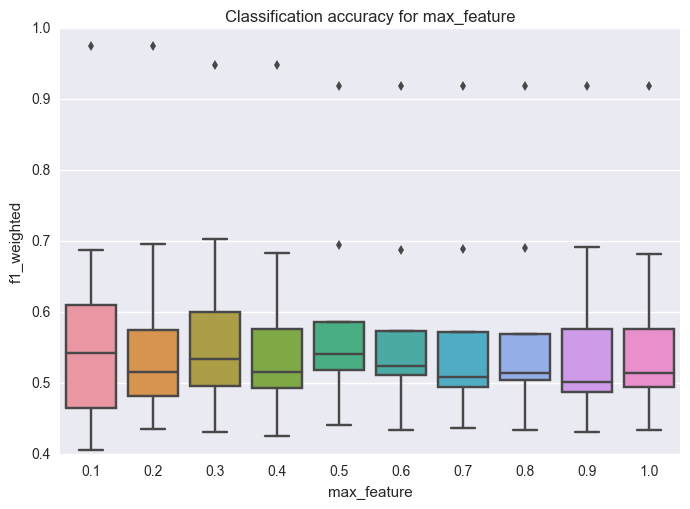

In [36]:
########### Tune max_features 
#rang = np.arange(10, 81, 10)
rang = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
scores = []

for val in rang:
    Cl = RandomForestClassifier(n_estimators=100, max_features=val, min_samples_split=20, min_samples_leaf=10,
                                class_weight='balanced', random_state=42, n_jobs=-1)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('max_feature')
plt.ylabel('f1_weighted')
plt.title('Classification accuracy for max_feature')
plt.show()

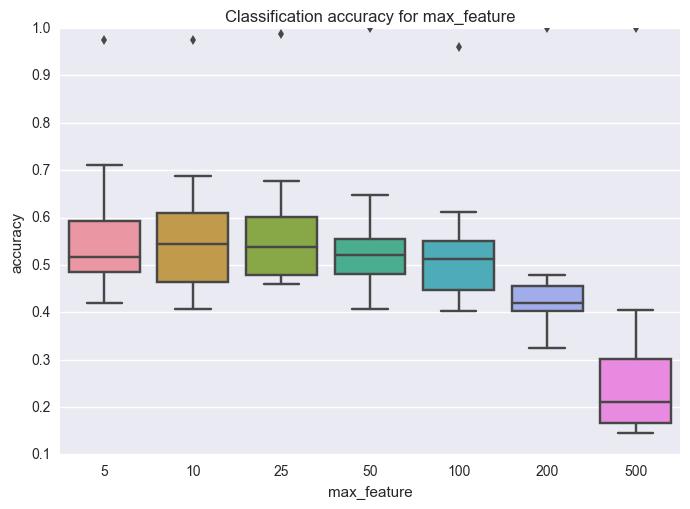

In [37]:
########### Tune min_sample_leaf 
#rang = np.arange(5, 50, 5)
rang = [5, 10, 25, 50, 100, 200, 500]
scores = []

for val in rang:
    Cl = RandomForestClassifier(n_estimators=100, max_features=0.1, min_samples_leaf=val,
                                class_weight='balanced', random_state=42, n_jobs=-1)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('max_feature')
plt.ylabel('accuracy')
plt.title('Classification accuracy for max_feature')
plt.show()

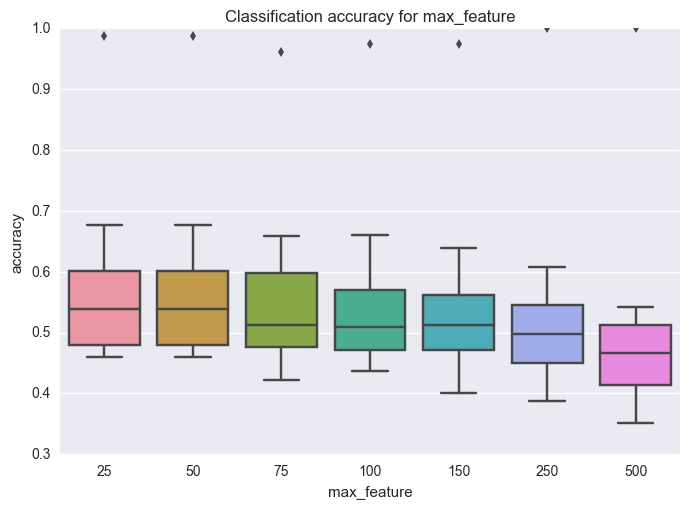

In [39]:
########### Tune min_sample_split 
#rang = np.arange(20, 100, 10)
rang = [25, 50, 75, 100, 150, 250, 500]
scores = []

for val in rang:
    Cl = RandomForestClassifier(n_estimators=100, max_features=0.1, min_samples_leaf=25,
                                min_samples_split=val, class_weight='balanced', random_state=42, n_jobs=-1)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('max_feature')
plt.ylabel('accuracy')
plt.title('Classification accuracy for max_feature')
plt.show()

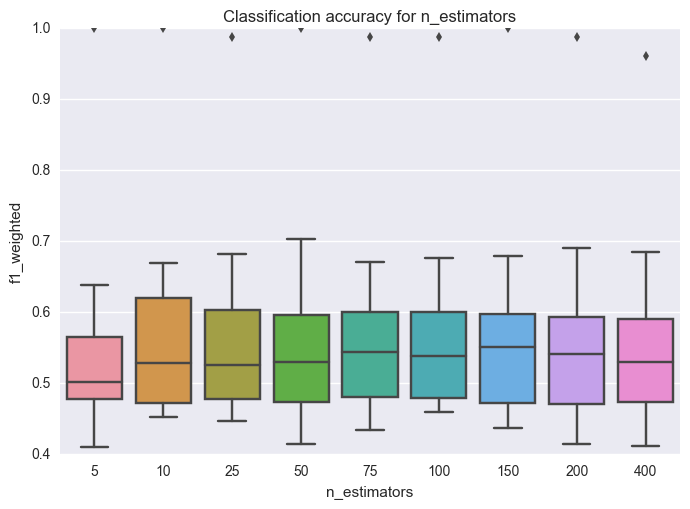

In [40]:
########### Train 
#rang = np.arange(10, 81, 10)
rang = [5, 10, 25, 50, 75, 100, 150, 200, 400]
scores = []

for val in rang:
    Cl = RandomForestClassifier(n_estimators=val, max_features=0.1, min_samples_leaf=25,
                                min_samples_split=50, class_weight='balanced', random_state=42, n_jobs=-1)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('n_estimators')
plt.ylabel('f1_weighted')
plt.title('Classification accuracy for n_estimators')
plt.show()

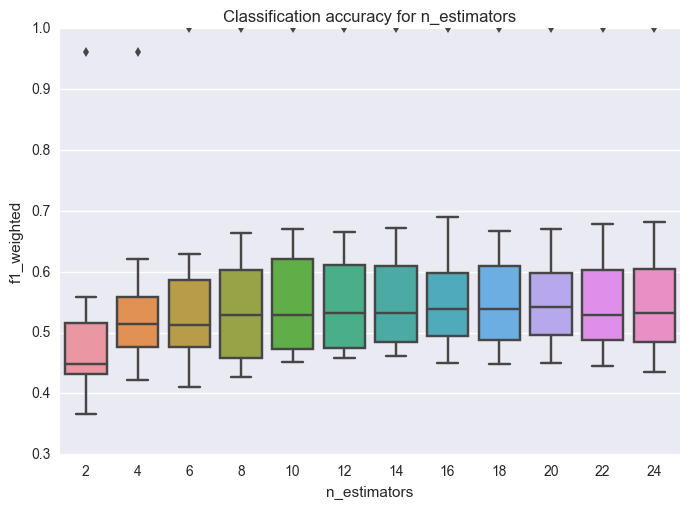

In [41]:
########### Train 
rang = np.arange(2, 25, 2)
#rang = [5, 10, 25, 50, 75, 100, 150, 200, 400, 600, 1000, 2000]
scores = []

for val in rang:
    Cl = RandomForestClassifier(n_estimators=val, max_features=0.1, min_samples_leaf=25,
                                min_samples_split=50, class_weight='balanced', random_state=42, n_jobs=-1)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('n_estimators')
plt.ylabel('f1_weighted')
plt.title('Classification accuracy for n_estimators')
plt.show()

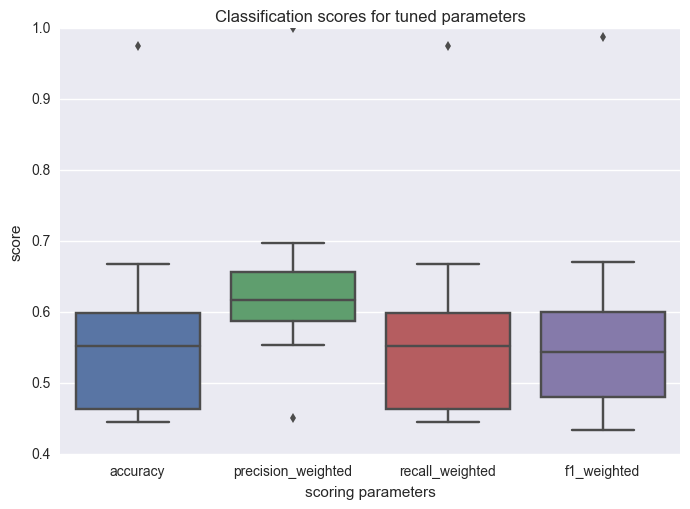

In [29]:
######### Estimation of final scores from this tuning:
scoring_param = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted' ]
scores = []

for scoring in scoring_param:
    Cl = RandomForestClassifier(n_estimators=75, max_features=0.1, min_samples_leaf=25,
                                min_samples_split=50, class_weight='balanced', random_state=42, n_jobs=-1)
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=scoring_param)
    
sns.boxplot(data=scores)

plt.xlabel('scoring parameters')
plt.ylabel('score')
plt.title('Classification scores for tuned parameters')
plt.show()

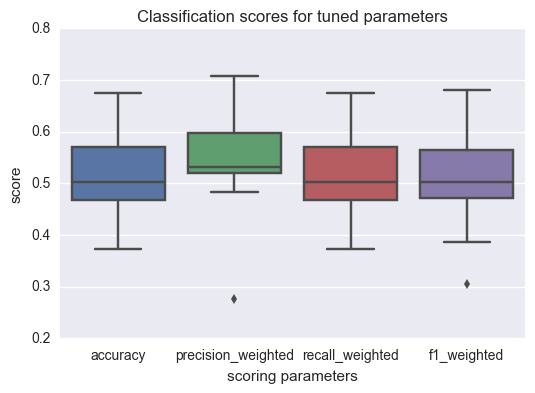

In [33]:
######### Estimation of final scores from this tuning:
scoring_param = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted' ]
scores = []

for scoring in scoring_param:
    Cl = RandomForestClassifier(n_estimators=75, max_features=0.1, min_samples_leaf=25,
                                min_samples_split=50, class_weight='balanced', random_state=42, n_jobs=-1)
    cv=LeavePGroupsOut(n_groups=2).split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=scoring_param)
    
sns.boxplot(data=scores)

plt.xlabel('scoring parameters')
plt.ylabel('score')
plt.title('Classification scores for tuned parameters')
plt.show()

OOB estimate of accuracy for prospectivity classification using all features: 0.73595505618
Feature ranking:
1. feature 282 Marine_ratio_5_centered (0.027510)
2. feature 284 Marine_ratio_15_centered (0.026943)
3. feature 5 NM_M (0.026028)
4. feature 288 Marine_ratio_75_centered (0.025525)
5. feature 292 dist_M_down (0.024927)
6. feature 285 Marine_ratio_20_centered (0.023031)
7. feature 290 Marine_ratio_200_centered (0.022655)
8. feature 287 Marine_ratio_50_centered (0.018130)
9. feature 283 Marine_ratio_10_centered (0.016744)
10. feature 286 Marine_ratio_30_centered (0.015869)
11. feature 293 dist_NM_up (0.014484)
12. feature 289 Marine_ratio_100_centered (0.013909)
13. feature 291 dist_M_up (0.013075)
14. feature 248 GR_moving_min_4ft (0.012916)
15. feature 271 PE_moving_min_7ft (0.012415)
16. feature 255 ILD_log10_moving_min_4ft (0.011933)
17. feature 41 PE_cA_level_3 (0.011794)
18. feature 82 PE_cA_level_4 (0.011274)
19. feature 81 PE_cA_level_3 (0.011214)
20. feature 1 ILD_log10 (

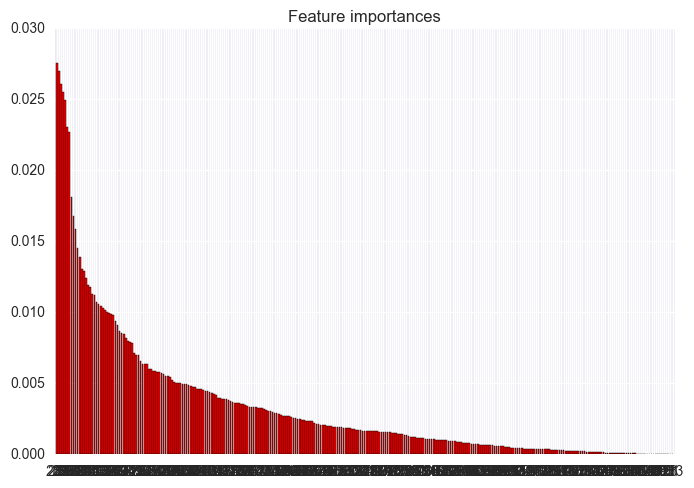

In [44]:
Cl = RandomForestClassifier(n_estimators=75, max_features=0.1, min_samples_leaf=25,
                            min_samples_split=50, class_weight='balanced', random_state=42,oob_score=True, n_jobs=-1)
Cl.fit(X, y)
print ('OOB estimate of accuracy for prospectivity classification using all features: %s' % str(Cl.oob_score_))

importances = Cl.feature_importances_ 
std = np.std([tree.feature_importances_ for tree in Cl.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
Vars = list(X.columns.values)
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], Vars[indices[f]], importances[indices[f]]))

########## Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],
       #color="r", yerr=std[indices], align="center")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()